# Imports

In [ ]:
! pip install plotly
! pip install hdbscan
! pip install seaborn
! pip install pinecone-client
! pip install openai

In [4]:
import openai
from openai.embeddings_utils import get_embedding, cosine_similarity
import os
import pandas as pd
from markdown import Markdown
from io import StringIO
import spacy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity as sk_cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import hdbscan
from collections import Counter
import pinecone
from tqdm import tqdm
import itertools
from ast import literal_eval
from prisma import Prisma

# Data Import

In [14]:
annotated_df = pd.read_csv("/Users/finnmacken/Desktop/Code/ChatStructure/annotated.csv")
annotated_df = annotated_df.dropna(subset=['label'])
annotated_df = annotated_df[annotated_df.label != 'False#True']

In [16]:
def unmark_element(element, stream=None):
    if stream is None:
        stream = StringIO()
    if element.text:
        stream.write(element.text)
    for sub in element:
        unmark_element(sub, stream)
    if element.tail:
        stream.write(element.tail)
    return stream.getvalue()


# patching Markdown
Markdown.output_formats["plain"] = unmark_element
__md = Markdown(output_format="plain")
__md.stripTopLevelTags = False


def unmark(text):
    return __md.convert(text)

annotated_df['text'] = annotated_df['text'].astype(str)
annotated_df['text'] = annotated_df['text'].apply(unmark)

In [17]:
print(set(annotated_df['label']))
annotated_df['label'] = annotated_df['label'].map({"False": "Other", "True": "Request", "False#Unsure": "Unsure", "True#Unsure": "Unsure", "Unsure": "Unsure"})
print(set(annotated_df['label']))

{'Unsure', 'True#Unsure', 'False#Unsure', 'True', 'False'}
{'Unsure', 'Other', 'Request'}


In [18]:
annotated_df.head()

,id,text,created_at,author,reference,embeds,mentions,attachments,label
0,1019191342687072276,!history,2022-09-13 10:22:31.756000+00:00,finn,NaN,[],[],[],Other
1,1019075643096432781,thanks for the feedback! i'll discuss it with ...,2022-09-13 02:42:46.824000+00:00,Alan Chan,<MessageReference message_id=10190620301766164...,[],[<User id=174103652556996608 name='robotic_sca...,[],Other
2,1019062030176616458,a couple feature requests:\nit would be fantas...,2022-09-13 01:48:41.251000+00:00,robotic_scarab,NaN,[],[],[<Attachment id=1019062029572649100 filename='...,Request
3,1019003148720951346,"yep, when letting go of the connection arrow i...",2022-09-12 21:54:42.818000+00:00,maxlinworm,<MessageReference message_id=10189863575924450...,[],[<User id=710847265581039616 name='Sams_Here' ...,[],Request
4,1018986357592445019,"if i may clarify, you want to create a new car...",2022-09-12 20:47:59.501000+00:00,Sams_Here,<MessageReference message_id=10189826926557266...,[],[<User id=776122030230732820 name='maxlinworm'...,[],Request


# Classify Feature Requests

In [19]:
openai.api_key = env("API_KEY")

In [20]:
i = 1500
def generate_response(x):  
    ft_model = "ada:ft-personal-2022-09-30-15-57-04"
    res = openai.Completion.create(model=ft_model, 
                                prompt= f'{x}\n\n###\n\n', max_tokens=1, temperature=0)
    return res['choices'][0]['text']

generate_response(200)

' Other'

In [21]:
def classify_df(df):
    df['prediction'] = df['text'].apply(lambda x: generate_response(x))
    return df

In [22]:
labelled_df = classify_df(annotated_df)

In [23]:
labelled_df['prediction'] = labelled_df['prediction'].apply(lambda x: x.strip())

In [24]:
labelled_df.head()

,id,text,created_at,author,reference,embeds,mentions,attachments,label,prediction
0,1019191342687072276,!history,2022-09-13 10:22:31.756000+00:00,finn,NaN,[],[],[],Other,Other
1,1019075643096432781,thanks for the feedback! i'll discuss it with ...,2022-09-13 02:42:46.824000+00:00,Alan Chan,<MessageReference message_id=10190620301766164...,[],[<User id=174103652556996608 name='robotic_sca...,[],Other,Other
2,1019062030176616458,a couple feature requests:\nit would be fantas...,2022-09-13 01:48:41.251000+00:00,robotic_scarab,NaN,[],[],[<Attachment id=1019062029572649100 filename='...,Request,Request
3,1019003148720951346,"yep, when letting go of the connection arrow i...",2022-09-12 21:54:42.818000+00:00,maxlinworm,<MessageReference message_id=10189863575924450...,[],[<User id=710847265581039616 name='Sams_Here' ...,[],Request,Request
4,1018986357592445019,"if i may clarify, you want to create a new car...",2022-09-12 20:47:59.501000+00:00,Sams_Here,<MessageReference message_id=10189826926557266...,[],[<User id=776122030230732820 name='maxlinworm'...,[],Request,Request


## Classification Analysis

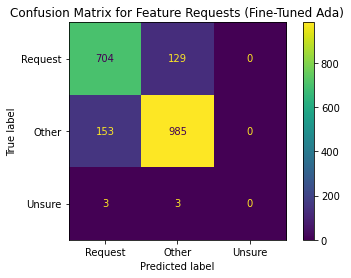

In [25]:
def generate_confusion_matrix(labelled_df):
    actual = np.array(labelled_df['label'])
    predicted = np.array([i.strip() for i in labelled_df['prediction']])
    
    cm = confusion_matrix(actual, predicted, labels=["Request", "Other", "Unsure"])
    display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=["Request", "Other", "Unsure"]).plot()
    plt.title("Confusion Matrix for Feature Requests (Fine-Tuned Ada)")

generate_confusion_matrix(labelled_df)

In [26]:
feature_requests_df = labelled_df[labelled_df['prediction'] == "Request"]


In [30]:
feature_requests_df.head()

,id,text,created_at,author,reference,embeds,mentions,attachments,label,prediction
2,1019062030176616458,a couple feature requests:\nit would be fantas...,2022-09-13 01:48:41.251000+00:00,robotic_scarab,NaN,[],[],[<Attachment id=1019062029572649100 filename='...,Request,Request
3,1019003148720951346,"yep, when letting go of the connection arrow i...",2022-09-12 21:54:42.818000+00:00,maxlinworm,<MessageReference message_id=10189863575924450...,[],[<User id=710847265581039616 name='Sams_Here' ...,[],Request,Request
4,1018986357592445019,"if i may clarify, you want to create a new car...",2022-09-12 20:47:59.501000+00:00,Sams_Here,<MessageReference message_id=10189826926557266...,[],[<User id=776122030230732820 name='maxlinworm'...,[],Request,Request
5,1018982692655726672,create a new card by clicking in empty space i...,2022-09-12 20:33:25.712000+00:00,maxlinworm,NaN,[],[],[<Attachment id=1018982691296784435 filename='...,Request,Request
9,1016745192277159936,when clicking outside of a card on a whiteboar...,2022-09-06 16:22:24.051000+00:00,robotic_scarab,NaN,[],[],[<Attachment id=1016745191681572895 filename='...,Request,Request


# Extract Feature Requests

In [31]:
def extract_feature_requests(x):
    res = openai.Completion.create(model="text-davinci-002", 
                                    prompt="Tell me what features this user is requesting. \n" + x + "\n Feature Requests:", 
                                    temperature=0, 
                                    max_tokens=300)
    return res['choices'][0]['text']

In [32]:
def extract_df(df):
    df['fr'] = df['text'].apply(lambda x: extract_feature_requests(x))
    return df

extracted_df = extract_df(feature_requests_df)

/var/folders/_n/c17wd9k97s7dm583pk_qqyjh0000gn/T/ipykernel_64332/666345732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fr'] = df['text'].apply(lambda x: extract_feature_requests(x))


In [36]:
extracted_df.to_csv("/Users/finnmacken/Desktop/Code/ChatStructure/ProductionTestOutputs/extracted_df")

In [5]:
extracted_df = pd.read_csv("/Users/finnmacken/Desktop/Code/ChatStructure/ProductionTestOutputs/extracted_df")

In [22]:
index = 450
print(extracted_df.iloc[index, [2, 11]]['text'])
print(extracted_df.iloc[index, [2, 11]]['fr'])

i'd love a way to export a card into a pdf or even be able to just copy paste it into slack while retaining the images like in bear
 
1. Exporting a card into a PDF
2. Copying and pasting a card into Slack while retaining images


In [103]:
extracted_df['fr'] = extracted_df['fr'].str.split("\n")
exploded_df = extracted_df.explode("fr")

In [104]:
exploded_df = exploded_df[~exploded_df["fr"].isin(['', " ", "  "])]
print(len(exploded_df))

1867


In [105]:
exploded_df.rename(columns={"id": 'message_id'}, inplace=True)

In [111]:
exploded_df = exploded_df.reset_index(drop=True)

In [119]:
exploded_df["fr_id"] = exploded_df.apply(lambda x: f"{x['message_id']}{hash(x['fr'])}", axis=1)

# Clustering

In [121]:
exploded_df["sim_embedding"] = exploded_df['fr'].apply(lambda x: get_embedding(x, engine="text-similarity-babbage-001"))

In [122]:
exploded_df.to_csv("/Users/finnmacken/Desktop/Code/ChatStructure/ProductionTestOutputs/exploded_df")

## K-Means

In [123]:
matrix = np.vstack(exploded_df['sim_embedding'].values)

In [124]:
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_

In [125]:
exploded_df['kmeans_labels'] = labels

### Analysis

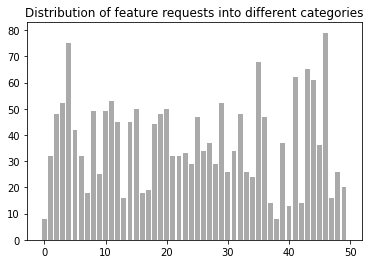

In [126]:
clusters = dict(sorted(dict(Counter(labels)).items()))
plt.bar(list(clusters.keys()), list(clusters.values()), color='#AAAAAA')
plt.title("Distribution of feature requests into different categories")
plt.show()

# Renaming

In [135]:
exploded_df = exploded_df.rename(columns={'text': 'message'})

In [ ]:
exploded_df.head()

# Search

In [137]:
exploded_df["search_embedding"] = exploded_df['fr'].apply(lambda x: get_embedding(x, engine="text-search-babbage-doc-001"))

In [105]:
exploded_df["fr_id"] = exploded_df.apply(lambda x: f"{x['message_id']}{hash(x['fr'])}", axis=1)

In [107]:
exploded_df.to_csv("/Users/finnmacken/Desktop/Code/ChatStructure/ProductionTestOutputs/exploded_search_df")

In [96]:
exploded_df = pd.read_csv("/Users/finnmacken/Desktop/Code/ChatStructure/ProductionTestOutputs/exploded_search_df")
exploded_df["search_embedding"] = exploded_df["search_embedding"].map(json.loads)

## Pinecone Upload

In [104]:
# pinecone.init(api_key="6d627fcf-c8fe-4139-a923-efc89a651f88", environment="us-west1-gcp")
# index = pinecone.Index("terrarium")
# index.delete(delete_all=True)

{}

In [108]:
def preprocess_embeddings(dataframe):
    embeddings = dataframe.loc[:, ['fr_id', 'search_embedding']]
    embeddings.columns = ['id', 'values']
    # embeddings['values'] = embeddings['values'].apply(literal_eval)
    return embeddings

In [109]:
preprocess_embeddings(exploded_df)

,id,values
0,10190620301766164583262674047531762287,"[-0.004777181427925825, 0.042440176010131836, ..."
1,1019062030176616458-1415130817690778901,"[0.012828316539525986, 0.0011032710317522287, ..."
2,10190031487209513464644656457084113336,"[0.029440756887197495, 0.014846691861748695, -..."
3,10190031487209513461988579829053545912,"[0.04014235734939575, 0.015832846984267235, -0..."
4,1018986357592445019-171445030898930826,"[0.031373728066682816, 0.049813877791166306, -..."
...,...,...
1862,8561372007898808948599159135424530898,"[0.0070258695632219315, 0.03533341735601425, -..."
1863,8561372007898808942924584296915428630,"[0.012334934435784817, 0.018388889729976654, -..."
1864,856137200789880894-225967667873902691,"[0.02048768848180771, 0.019217712804675102, -0..."
1865,856134368228409384-2433429182015928174,"[0.012097869999706745, 0.02703668922185898, 0...."


In [110]:
def batches(iterable, batch_size):
  """Helper function to break an iterable into chunks of size batch_size."""
  it = iter(iterable)
  chunk = list(itertools.islice(it, batch_size))
  while chunk:
      yield chunk
      chunk = list(itertools.islice(it, batch_size))

def batch_upload(vector_list, pinecone_index, batch_size):
  for vector_batch in batches(vector_list, batch_size=batch_size):
    pinecone_index.upsert(vectors=vector_batch)

In [111]:
def async_batch_upload(vector_list, batch_size=100):
    with pinecone.Index("terrarium", pool_threads=30) as index:
        async_results = [
            index.upsert(vectors=id_vectors_chunk, async_req=True)
            for id_vectors_chunk in tqdm(batches(vector_list, batch_size))
        ]

        return [async_result.get() for async_result in async_results]


In [112]:
def schematize_and_upload_embeddings(unprocessed_data):
    pinecone.init(api_key="6d627fcf-c8fe-4139-a923-efc89a651f88", environment="us-west1-gcp")
    index = pinecone.Index("terrarium")

    data = preprocess_embeddings(unprocessed_data)
    data_itertuples = list(data.itertuples(index=False, name=None))
    return async_batch_upload(data_itertuples)            

In [113]:
schematize_and_upload_embeddings(exploded_df)

19it [00:00, 440.88it/s]


[{'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 100},
 {'upserted_count': 67}]

# Exporting to JSON

In [82]:
output_df = exploded_df.loc[:, ['message_id', 
                                'message', 
                                'created_at',
                                'author',
                                'label',
                                'fr',
                                'fr_id',
                                'kmeans_labels'
                                ]]

In [ ]:
output_df.head()

In [83]:
output_df.to_json("/Users/finnmacken/Desktop/Code/ChatStructure/ProductionTestOutputs/final_output.json", orient='records', index=True)

# Database Upload

In [88]:
output_df = pd.read_json("/Users/finnmacken/Desktop/Code/ChatStructure/ProductionTestOutputs/final_output.json", orient="records")

In [89]:
output_df

,message_id,message,created_at,author,label,fr,fr_id,kmeans_labels
0,1019062030176616448,a couple feature requests:\nit would be fantas...,2022-09-13 01:48:41.251,robotic_scarab,Request,1. Collapsing whiteboards,10190620301766164583262674047531762287,25
1,1019062030176616448,a couple feature requests:\nit would be fantas...,2022-09-13 01:48:41.251,robotic_scarab,Request,2. Setting size of collapsed card's title,1019062030176616458-1415130817690778901,36
2,1019003148720951296,"yep, when letting go of the connection arrow i...",2022-09-12 21:54:42.818,maxlinworm,Request,1. A new card should be created when the user ...,10190031487209513464644656457084113336,11
3,1019003148720951296,"yep, when letting go of the connection arrow i...",2022-09-12 21:54:42.818,maxlinworm,Request,2. The user should be able to connect two card...,10190031487209513461988579829053545912,32
4,1018986357592445056,"if i may clarify, you want to create a new car...",2022-09-12 20:47:59.501,Sams_Here,Request,-The ability to create a new card when draggin...,1018986357592445019-171445030898930826,41
...,...,...,...,...,...,...,...,...
1860,856137200789880832,type tool\na button somewhere on the board wit...,2021-06-20 11:43:34.928,Vincer,Request,-The ability to click on an empty space and cr...,8561372007898808948599159135424530898,43
1861,856137200789880832,type tool\na button somewhere on the board wit...,2021-06-20 11:43:34.928,Vincer,Request,"-The ability to click away, select something e...",8561372007898808942924584296915428630,43
1862,856137200789880832,type tool\na button somewhere on the board wit...,2021-06-20 11:43:34.928,Vincer,Request,-The ability to click on the outside rectangle...,856137200789880894-225967667873902691,45
1863,856134368228409344,1) multi-select (ctr/cmd or shift clicking)\n+...,2021-06-20 11:32:19.593,Vincer,Request,1. The ability to select multiple notes at onc...,856134368228409384-2433429182015928174,43


In [84]:
output_df['message_id'] = output_df['message_id'].map(str)
output_df['kmeans_labels'] = output_df['kmeans_labels'].map(int)

output_df = output_df.drop_duplicates(subset=['fr_id'])

In [85]:
output_df["fr_id"] = output_df.apply(lambda x: f"{x['message_id']}{hash(x['fr'])}", axis=1)

/var/folders/_n/c17wd9k97s7dm583pk_qqyjh0000gn/T/ipykernel_12422/1785710592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df["fr_id"] = output_df.apply(lambda x: f"{x['message_id']}{hash(x['fr'])}", axis=1)


In [78]:
output_dicts = output_df.to_dict(orient='records')

In [79]:
for output_dict in output_dicts:
    output_dict.update({'userId': "110421822788553907926"})

In [80]:
output_dicts[0]['fr_id']

'10190620301766164583262674047531762287'

In [81]:
from prisma.models import FeatureRequest
fr = output_df.iloc[0, :]

# db = Prisma(auto_register=True)
db = Prisma()
await db.connect()

batcher = db.batch_()
for fr in output_dicts:
    await FeatureRequest.prisma().upsert(
        where={
            "fr_id": fr["fr_id"]
        },
        data = {
            'create': {
                "fr_id": fr["fr_id"],
                "message_id": str(fr["message_id"]),
                "message": fr["message"],
                "created_at": fr['created_at'],
                "author": fr["author"],
                "label": fr["label"],
                "fr": fr['fr'],
                "kmeans_labels": int(fr["kmeans_labels"]),
                "userId": "110421822788553907926"
            },
            'update': {
                "fr_id": fr["fr_id"],
                "message_id": str(fr["message_id"]),
                "message": fr["message"],
                "created_at": fr['created_at'],
                "author": fr["author"],
                "label": fr["label"],
                "fr": fr['fr'],
                "kmeans_labels": int(fr["kmeans_labels"]),
                "userId": "110421822788553907926"
            }
        }
    )
await batcher.commit()

await db.disconnect()